# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

The base `SVM` class below defines a common interface for a support vector machine. 
Your implementations below for each task of the project should inherit from this class. Feel free to add to this class if you need.

In [4]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self) -> None:
        pass
        
    @abstractmethod
    def fit(self, X, y) -> None:        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
    
    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        
    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### Binary classification data
We will generate some toy binary classification data, re-using the code from workshop 4. This will be used for tasks 1-3.

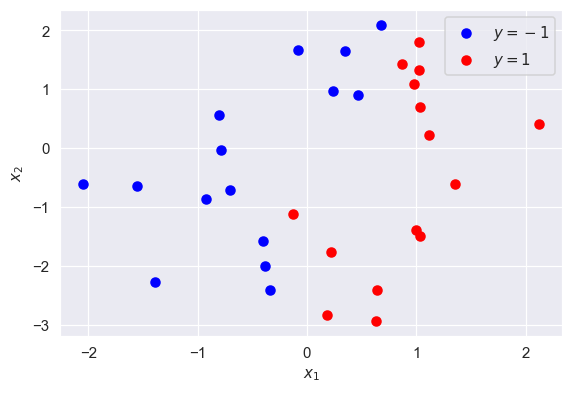

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Task 1: Primal soft-margin SVM

In [44]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training 
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """
    
    def __init__(self, eta, lambda0) -> None:
        self.eta = eta
        super().__init__()
        self.lambda0 = lambda0  
        self.weights = None 
        self.bias = None
        ### end of your code ###
        
    def fit(self, X, y, iterations = 100) -> None:
    
        super().fit(X=X,y=y)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0 
        for i in range(iterations): # for two options
            for j in range(n_samples):
                if (y[j] * (np.dot(X[j], self.weights) + self.bias)) < 1:
                    # when loss fuction is eat*-yj *xj + lambda * weights and bias is eat *yj
                    self.weights -= self.eta * (-y[j] * X[j] + self.lambda0 * self.weights)
                    self.bias += self.eta * y[j]
                else:
                    #when loss fucntion is lambda*weight, and bias = 0 
                    self.weights -= self.eta * self.lambda0 * self.weights
        ### end of your code ###
        
            
    def predict(self, test_X) -> int: 
        super().predict(test_X = test_X)
        ## your code here ###
        return np.sign(np.dot(test_X, self.weights) + self.bias)
        ### end of your code ###

Accuracy is 0.9


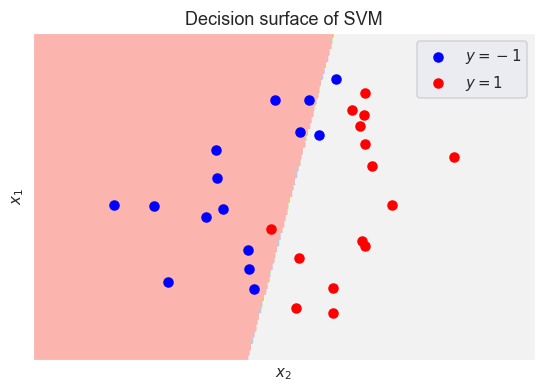

In [45]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
psvm.visualize(X,y)

### Tuning lambda value

In [171]:
# Use this cell for experimentation 1.b
lambdas = np.logspace(-5, 2, 10)  

best_lambda = None
best_accuracy = 0

for lambda0 in lambdas:
    psvm = PrimalSVM(eta=0.1, lambda0=lambda0)
    psvm.fit(X,y, iterations = 100)
    
    
    print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
    accuracy = round(psvm.evaluate(X,y),4)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lambda0

print(f"Best lambda: {best_lambda}")
print(f"Best accuracy on validation set: {best_accuracy}")

Accuracy is 0.9667
Accuracy is 0.9667
Accuracy is 0.9667
Accuracy is 0.9667
Accuracy is 0.9667
Accuracy is 0.9
Accuracy is 0.9
Accuracy is 0.7667
Accuracy is 0.4333
Accuracy is 0.0
Best lambda: 1e-05
Best accuracy on validation set: 0.9667


/var/folders/_d/fh70syld2d917rzkkr3k1w8h0000gn/T/ipykernel_54774/2215263156.py:31: RuntimeWarning: overflow encountered in multiply
  self.weights -= self.eta * (-y[j] * X[j] + self.lambda0 * self.weights)
/var/folders/_d/fh70syld2d917rzkkr3k1w8h0000gn/T/ipykernel_54774/2215263156.py:35: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.eta * self.lambda0 * self.weights


## Task 2: Dual soft-margin SVM

In [74]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        ## your code here ###
        self.eta = eta 
        self.C = C
        ### end of your code ###
    
    def fit(self, X, y, iterations = 100):
        
        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        
        ### your code here ###
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)# lagrange multipliers (sometimes denoted lambda), you should initialize with 0s

        
        for j in range(iterations):
            for i in range(n_samples):
                gradient = 1 - y[i] * np.sum(self.alpha * y * self.kernel(X, X[i]))
                self.alpha[i] += self.eta * gradient

             # two outcome, <0 or > C
                for n in range(len(self.alpha)):
                    if self.alpha[n]<0:
                        self.alpha[n] = 0
                    elif self.alpha[n]> self.C:
                        self.alpha[n] =self.C
        ### end of your code ###
        self.bias = self.get_bias()
            
        return 
     
    def predict(self, test_X):
        super().predict(test_X =test_X)
        ### your code here ###
        predictions = []
        for x in test_X:
            result = self.bias + np.sum(self.alpha * self.y * self.kernel(x, self.X))
            predictions.append(np.sign(result))
        return np.array(predictions)

        ### end of your code ###
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        ### your code here ###
        return np.dot(self.alpha * self.y, self.X)
        ### end of your code ###
        
    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """
        ### your code here ###
        return np.mean(self.y - np.sum(self.alpha * self.y * self.kernel(self.X, self.X), axis=1))
        ### end of your code ###

Accuracy is 0.9667


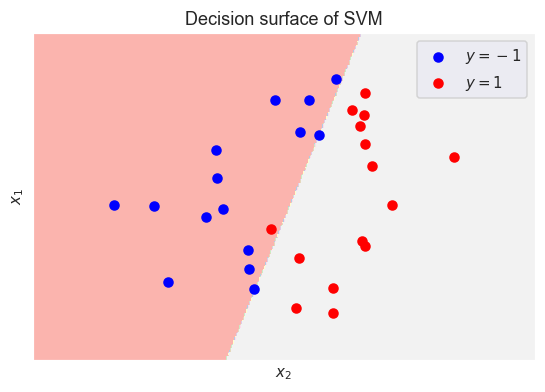

In [146]:
dsvm = DualSVM(eta = 0.1, C = 100)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

### Tuning C value

In [235]:
# Use this cell here for experimentation 2.a

C_values = [0.01, 0.1, 1, 10, 100,200]


best_C = None
best_accuracy = 0


for C in C_values:
    model = DualSVM(eta=0.1, C= C)
    model.fit(X, y,iterations = 100)
    accuracy = model.evaluate(X, y)
    
    print(f"Accuracy with C={C}: {round(accuracy,4)}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Best C value is {best_C} with accuracy {round(best_accuracy,4)}")


Accuracy with C=0.01: 0.9333
Accuracy with C=0.1: 0.9
Accuracy with C=1: 0.9333
Accuracy with C=10: 0.9333
Accuracy with C=100: 0.9667
Accuracy with C=200: 0.9667
Best C value is 100 with accuracy 0.9667


### Compare weights between primal and dual

In [236]:
# Use this cell here for experimentation 2.b
from numpy.linalg import norm
#train dual SVM
dual_svm = DualSVM(eta=0.1, C=best_C)
dual_svm.fit(X, y,iterations = 100)
dual_weights = dual_svm.primal_weights()
dual_unit = dual_weights / norm(dual_weights)
print(dual_weights)
#train primal SVM with equivalent loss
lambda_value = 1/best_C
primal_svm = PrimalSVM(eta=0.1, lambda0= lambda_value)
primal_svm.fit(X, y,iterations =100)
primal_weights = primal_svm.weights
primal_unit = primal_weights / norm(primal_weights)
print(primal_weights)
#compare weights

difference = norm(dual_unit - primal_unit)
print(f"Norm of the difference between dual and primal weights: {difference}")
#the weights are very similar

[ 1.41067863 -0.33298488]
[ 3.76433292 -0.77330477]
Norm of the difference between dual and primal weights: 0.029191164892392013


### Identify support vectors and points where alpha=C

In [253]:
# Use this cell here for experimentation 2.c
vector_list = []
support_vector_indices = np.where(dual_svm.alpha > 0)[0]
alpha_equals_C_indices = np.where(dual_svm.alpha == 100)[0]

vector_list = []

for i in support_vector_indices :
    vector = dual_svm.alpha[i]
    vector_list.append(round(vector,4))

print(f"Support vector indices: {support_vector_indices}")
print(f"Support vector :{vector_list}")
print(f"Indices where alpha equals C: {alpha_equals_C_indices} There's no points alpha = C within 100 iterations when c = 100 ")


Support vector indices: [ 0  2  3  6  7  8  9 10 16 18 20 22 23 24 26 29]
Support vector :[0.2872, 12.5464, 0.9301, 7.4423, 18.0267, 0.1818, 2.4418, 8.8806, 2.9626, 9.6451, 15.0228, 0.4918, 1.6671, 12.096, 7.2866, 13.0822]
Indices where alpha equals C: [] There's no points alpha = C within 100 iterations when c = 100 


## Task 3: Kernel

In [229]:
from numpy.linalg import norm

    
class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    poly_degree: int
        Polynomial degree for polynormial kernel. 
    poly_offset: float
        Polynomial offset for polynomial kernel. 
    rbf_sigma: float
        Kernel coefficient for rbf kernel. 
    """
    
    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.sigma = kwargs.get('rbf_sigma')
            self.kernel = self.rbf_kernel
            
    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)
        
        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        return self.kernel(u, v)
        
    def linear_kernel(self, u, v):
        return np.dot(u,v.T)

    def poly_kernel(self, u, v):
        ### your code here ###
        return (np.dot(u, v.T) + self.sigma) ** self.degree
        ### end of your code ###

    def rbf_kernel(self, u, v):
        ### your code here ###
        if len(u.shape) == 1:
            u = u.reshape(1, -1)
        if len(v.shape) == 1:
            v = v.reshape(1, -1)

        #squared distance between each pair of vectors in u and v
        sq_distance = np.sum(u**2, axis=1).reshape(-1, 1) + np.sum(v**2, axis=1) - 2 * np.dot(u, v.T)

        rbf = np.exp(-self.sigma * sq_distance)
    
        return rbf
        ### end of your code ###

### Test your kernel in the DualSVM

Accuracy is 0.9667


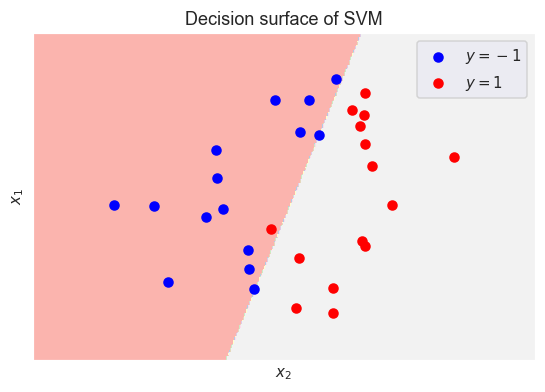

In [238]:
# Use this cell here for experimentation 3, e.g., 

svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

Accuracy is 0.9667


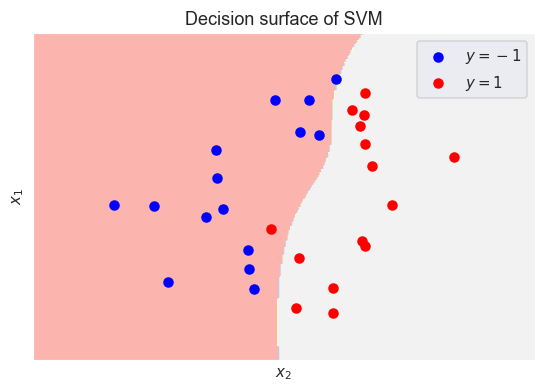

In [239]:
svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly',poly_degree=4,poly_offset=3))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

Accuracy is 1.0


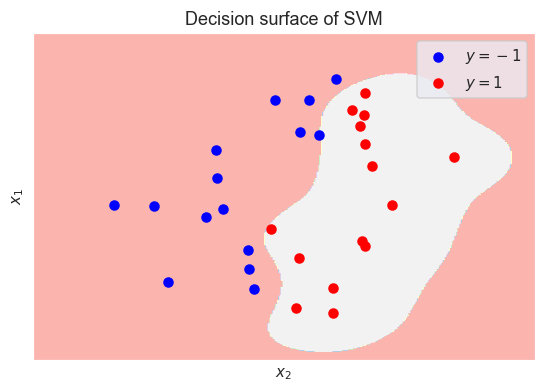

In [252]:
svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 2))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

[In a few sentences, explain which kernel you think is best suited to this problem, and why.]

From the comparison above, I would say the RBF kernel is the most suitable kernel for this problem as it has the highest accuracy out of all three kernels under the same iterations. As the plot shows we see it has definite the boundary very clear for the blue and red dots. As the iterations increase the boundary becomes more clear. The reason being is because RBF is capable of handeling non-linear relationoships in the data, it can map the data into a higher dimensional space and therefore have more information to decide the boundary. 